In [0]:
from skimage.io import imread
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

from IPython.display import clear_output, display_png

In [ ]:
# uncomment below code to upload the required content and style images on google colab server

# from google.colab import files

# files.upload()

In [0]:
# specify paths to content and style images

CONTENT_IMG_PATH = "dancing girl.jpg"
STYLE_IMG1_PATH = "red-canna.jpg"
STYLE_IMG2_PATH = "seated-nude.jpg"

In [0]:
# global constants

# the max dimension for generated image
MAX_DIM = 512

# layers to consider for extracting intermediate features from vgg model
CONTENT_FEATURE_LAYER = 'block4_conv2'
STYLE_FEATURE_LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']#, 'block5_conv1']

LEN_STYLE_LAYERS = len(STYLE_FEATURE_LAYERS)

# mean values required for unprocessing step
DATASET_MEAN = np.array([103.939, 116.779, 123.68])

# for clipping the generated image at each step
MIN_VALS = -DATASET_MEAN
MAX_VALS = 255 - DATASET_MEAN

# content and style weights for computing losses
ALPHA = 10.0
BETA1 = 1500.0
BETA2 = 1500.0

# no of iterations for which the neural style transfer algorithm is run
EPOCHS = 2000

# interval after which generated image is displayed during the loop
IMG_DISPLAY_INTERVAL = 100

Shape of content image :  (1280, 863, 3)


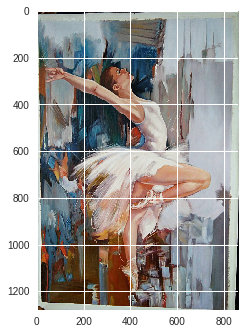

In [5]:
# This is the content image

content_img = imread(CONTENT_IMG_PATH)

print("Shape of content image : ", content_img.shape)
imshow(content_img)

Shape of style image :  (840, 700, 3)


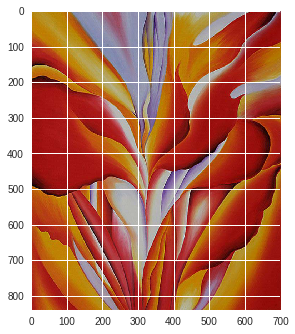

In [6]:
# This is the first style image

style_img1 = imread(STYLE_IMG1_PATH)

print("Shape of style image : ", style_img1.shape)
imshow(style_img1)

Shape of style image :  (845, 650, 3)


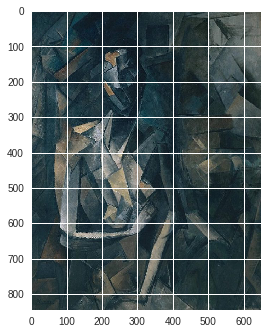

In [7]:
# This is the second style image

style_img2 = imread(STYLE_IMG2_PATH)

print("Shape of style image : ", style_img2.shape)
imshow(style_img2)

In [8]:
# enabling eager execution in tf

tf.enable_eager_execution()

print("Is Eager-execution enabled : ", tf.executing_eagerly())

Is Eager-execution enabled :  True


In [0]:
# loads the content image and scales it down to MAX_DIM maximum dimension
# along with adding an extra dimension of 1 to it ( as required by input of vgg model)

def load_and_reshape_content_img(img_path):
    img = Image.open(img_path)
   
    larger_dim = max(img.size)
    scale = MAX_DIM/larger_dim
    
    content_x = int(scale*img.size[0])
    content_y = int(scale*img.size[1])
    
    img = img.resize((content_x, content_y), Image.ANTIALIAS)
    
    img = np.asarray(img)
    # extra dimension of 1 added
    img = np.expand_dims(img, axis=0)
    
    return img, content_x, content_y

In [0]:
# loads the style image and scales it down to dimensions of content image
# along with adding an extra dimension of 1 to it ( as required by input of vgg model)

def load_and_reshape_style_img(img_path, style_x, style_y):
    img = Image.open(img_path)
    
    img = img.resize((style_x, style_y), Image.ANTIALIAS)
    
    img = np.asarray(img)
     # extra dimension of 1 added
    img = np.expand_dims(img, axis=0)
    
    return img

In [0]:
# preprocessing step required before feeding the input to vgg model

def preprocess_img(img):
    
    img = tf.keras.applications.vgg19.preprocess_input(img)    
    return img

In [0]:

# To unprocess the generated image before displaying as output.

# this is required because the preprocessing step involving subtracting mean rgb values
# of imagenet dataset is applied to the input.
# So mean rgb values are now ADDED to generated image (reverse of preprocessing)

def unprocess_img(img):
    
    local_img = np.copy(img)
    # removing first dimension of 1
    local_img = np.squeeze(local_img, axis = 0)
    
    # adding mean rgb values of imagenet dataset
    for idx, val in enumerate(DATASET_MEAN):
        local_img[:, :, idx] += val
        
    local_img = local_img[:, :, ::-1]    
    # clipping image pixels between 0-255
    local_img = np.clip(local_img, 0, 255).astype('uint8')
    
    return local_img

In [0]:
# loading and preprocessing content image
content_img, content_x, content_y = load_and_reshape_content_img(CONTENT_IMG_PATH)
content_img = preprocess_img(content_img)

# loading and preprocessing first style image
style_img1 = load_and_reshape_style_img(STYLE_IMG1_PATH, content_x, content_y)
style_img1 = preprocess_img(style_img1)

# loading and preprocessing second style image
style_img2 = load_and_reshape_style_img(STYLE_IMG2_PATH, content_x, content_y)
style_img2 = preprocess_img(style_img2)

# making a copy of content image to function as the default generated image 
generated_img = np.copy(content_img)

In [14]:
# shapes of content, style and generated images should be equal

print("Shape of Content Image : ", content_img.shape)
print("Shape of Style Image 1 : ", style_img1.shape)
print("Shape of Style Image 2 : ", style_img2.shape)
print("Shape of Generated Image : ", generated_img.shape)

Shape of Content Image :  (1, 512, 345, 3)
Shape of Style Image 1 :  (1, 512, 345, 3)
Shape of Style Image 2 :  (1, 512, 345, 3)
Shape of Generated Image :  (1, 512, 345, 3)


In [15]:
# load the pretrained vgg model and set model parameters to be untrainable

vgg_model = VGG19(include_top=False, weights='imagenet')
vgg_model.trainable = False


80142336/80134624 [==============================] - 1s 0us/step


In [0]:
# extract content feature layer output of CONTENT_FEATURE_LAYER declared earlier
content_output = [vgg_model.get_layer(CONTENT_FEATURE_LAYER).output]

style_outputs = []
# extract style feature layers output from STYLE_FEATURE_LAYERS declared earlier
for layer_name in STYLE_FEATURE_LAYERS:
    style_output = vgg_model.get_layer(layer_name).output
    style_outputs.append(style_output)
    

# concatenate both content outputs and style outputs to function as final output of custom nst_model
both_outputs = content_output + style_outputs


In [0]:
# create custom model for neural style transfer using functional API
# that takes as input the input image required by vgg model
# and outputs the specified layers for extracting required
# content feature layer and style feature layers

nst_model = Model(vgg_model.input, both_outputs)

for layer in nst_model.layers:
    layer.trainable = False

In [0]:
# creates gram matrix from given matrix

def get_gram_matrix(mat):

    _ , height, width, channels = mat.get_shape().as_list()
        
    mat = tf.reshape(mat, [height*width, channels])
    h_w    = tf.shape(mat)[0]
    
    gram_mat = tf.matmul(mat, mat, transpose_a = True)/ tf.cast(h_w, tf.float32)
    
    return gram_mat

In [0]:

# pass content image through custom model and get all features
content_img_all_features = nst_model(content_img)

# extracts computed features from output of first layer ( i.e. content layer)
content_img_required_feature = content_img_all_features[0]


In [0]:
# FIRST style image features extraction

# pass style image through custom model and get all features
style_img1_all_features = nst_model(style_img1)

# extracts computed features from output of layers beginning with 2nd layer ( 1st layer has output for content features)
style_img1_required_features = style_img1_all_features[1:]

# compute gram matrices for style output features of style image
style_img1_gram_features = [get_gram_matrix(feature) for feature in style_img1_required_features]

In [0]:
# SECOND style image features extraction

# pass style image through custom model and get all features
style_img2_all_features = nst_model(style_img2)

# extracts computed features from output of layers beginning with 2nd layer ( 1st layer has output for content features)
style_img2_required_features = style_img2_all_features[1:]

# compute gram matrices for style output features of style image
style_img2_gram_features = [get_gram_matrix(feature) for feature in style_img2_required_features]

In [0]:
# calculates euclidean distance between calculated features for content layer of generated image
# and pre-computed content feature for content image

def calc_content_cost(generated_img_content_feature): 
    
    _ , height, width, channels = generated_img_content_feature.get_shape().as_list()
    const_factor = 1/(4*height*width*channels)
    
    cost = const_factor * tf.reduce_sum(tf.square(tf.subtract(content_img_required_feature, generated_img_content_feature)))
    
    return cost

In [0]:
# calculates euclidean distance between calculated features for each given style layer of generated image
# and corresponding pre-computed style feature for style image

def calc_each_style_layer_cost(style_img_gram_feature, generated_img_style_feature):
    
    _ , height, width, channels = generated_img_style_feature.get_shape().as_list()
    const_factor = 1/(4*height*height*width*width*channels*channels)
    
    # compute gram matrix for style layer(s) of generated image
    generated_img_gram_feature = get_gram_matrix(generated_img_style_feature)
    cost = const_factor*tf.reduce_sum(tf.square(tf.subtract(style_img_gram_feature, generated_img_gram_feature)))
    
    return cost

In [0]:
# calculates total style cost by adding individual style costs from different style layers

def calc_style_cost(style_img_gram_features, generated_img_style_features):
    
    total_style_cost = 0
    
    for style_img_gram_feature, generated_img_style_feature in zip(style_img_gram_features, generated_img_style_features):
        
        each_style_layer_cost = calc_each_style_layer_cost(style_img_gram_feature, generated_img_style_feature)
        
        # multiplying style cost for each layer by the weight given to cost of that particluar layer,
        # which, in this case is just constant and equals 1/TOTAL_NO_OF_STYLE_LAYERS
        total_style_cost += LEN_STYLE_LAYERS*each_style_layer_cost

    return total_style_cost

In [0]:
# calculates total cost by adding 
# content cost between content layer of content image & generated image and
# style cost between all style layers of style image & generated image

def calc_total_cost(generated_img):
    
    # pass generated image through custom model to get all its content and style features
    generated_img_all_features = nst_model(generated_img)
    
    # first feature is output for content layer
    generated_img_content_feature = generated_img_all_features[0]
    # remaining all features correspond to output for style layers
    generated_img_style_features = generated_img_all_features[1:]
    
    # computing content cost and multiplying it by content weight i.e. ALPHA
    content_cost = calc_content_cost(generated_img_content_feature)
    content_cost *= ALPHA
    
    # computing style cost for FIRST style and multiplying it by corresponding style weight i.e. BETA1
    style1_cost = calc_style_cost(style_img1_gram_features, generated_img_style_features)
    style1_cost*= BETA1
    
    # computing style cost for SECOND style and multiplying it by corresponding style weight i.e. BETA2
    style2_cost = calc_style_cost(style_img2_gram_features, generated_img_style_features)
    style2_cost*= BETA2
    
    # overall cost is sum of content cost and style cost
    total_cost = content_cost + style1_cost + style2_cost
    
    return total_cost, content_cost, style1_cost, style2_cost

In [0]:
# computes model losses and gradients for update rule

def calc_loss_and_gradients(generated_img):
    
    # calculating cost in the context of GradientTape to record all involved operations 
    # in order to compute gradient
    with tf.GradientTape() as tape:
        total_cost, content_cost, style1_cost, style2_cost = calc_total_cost(generated_img)
        
    # calculates gradient of overall loss w.r.t generated image
    # to peform update operation for the generated image (i.e. tfe.Variable)
    return tape.gradient(total_cost, generated_img), total_cost, content_cost, style1_cost, style2_cost

In [0]:

# defining the optimizer
optimizer = tf.train.AdamOptimizer(5.0)


In [0]:

# defining the generated_img as a Variable to be able to perform gradient updates
generated_img = tfe.Variable(generated_img, dtype = tf.float32)


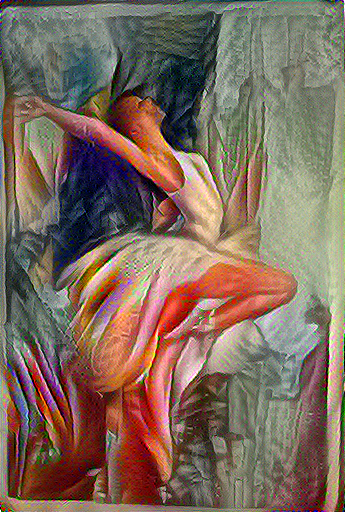

Iteration :  1900
Content Loss : 6.193e+05
Style 1 Loss : 8.786e+06
Style 2 Loss : 8.328e+06
Total Loss : 1.773e+07


In [29]:
# finally combining all the steps to repeatedly perform style transfer

for i in range(EPOCHS):
    
    # calculate loss and gradients
    grad, t_cost, c_cost, s1_cost, s2_cost = calc_loss_and_gradients(generated_img)
    # apply gradient update to generated_img variable
    optimizer.apply_gradients([(grad, generated_img)])
    
    # clipping the generated_img variable to confine the pixel values within a limit
    clipped_img = tf.clip_by_value(generated_img, MIN_VALS, MAX_VALS)
    generated_img.assign(clipped_img)
    
    
    # displays the losses and generated_img every pre-defined interval
    if i%IMG_DISPLAY_INTERVAL == 0 :
        
        # perform unprocessing of the generated image to display
        stylised_img = unprocess_img(generated_img.numpy())
        
        clear_output(wait=True)
        display_png(Image.fromarray(stylised_img))
        
        print("Iteration : ", i)
        print("Content Loss : {:.3e}".format(c_cost))
        print("Style 1 Loss : {:.3e}".format(s1_cost))
        print("Style 2 Loss : {:.3e}".format(s2_cost))
        print("Total Loss : {:.3e}".format(t_cost))

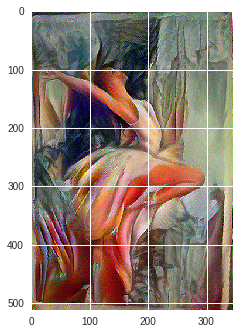

In [30]:
output = np.copy(unprocess_img(generated_img.numpy()))

imshow(output)

In [0]:
# uncomment below code to download the final generated image from google colab server to local disk

# from PIL import Image

# Image.fromarray(output).save("final.jpg")
# files.download("final.jpg")